## Project Option 1: Real-world applications of GNN


### SECTION 1

#### CORA DATASET

In [1]:
#importing necessary libraries
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch_geometric")
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader



In [2]:
# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')

# Check dataset information
print(f'Dataset: {dataset}:')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [3]:
# Access the data
data = dataset[0]  # Cora contains only one graph, so we use the first element

# Inspect the data
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Node feature dimension: {data.num_node_features}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Node feature dimension: 1433
Number of training nodes: 140
Is undirected: True


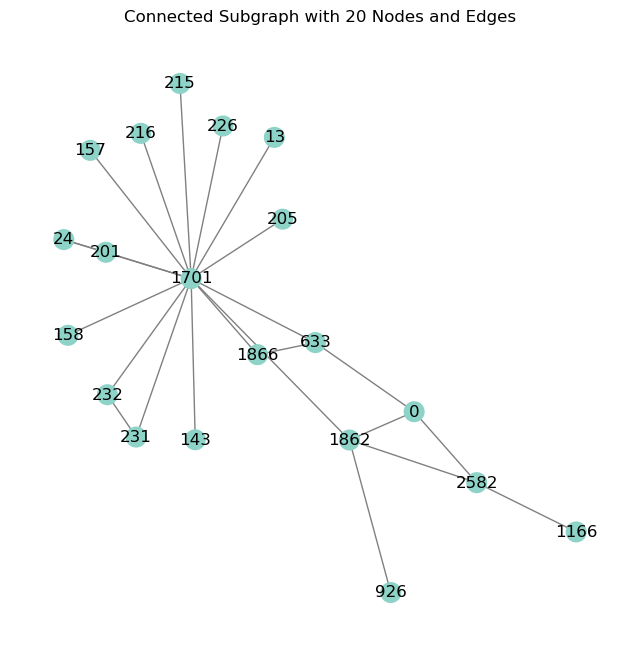

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Convert the PyTorch Geometric data to a NetworkX graph
G = to_networkx(data, to_undirected=True)

# Select a node to start the BFS or DFS from
start_node = list(G.nodes())[0]  

# Use BFS to get a connected subgraph of 20 nodes
connected_nodes = list(nx.bfs_tree(G, start_node, depth_limit=20).nodes)[:20]  # BFS ensures connected nodes

# Create a subgraph from the connected nodes
connected_subgraph = G.subgraph(connected_nodes)

# Get the class labels for the subset of nodes (Cora has 7 classes)
subset_node_colors = [data.y[node].item() for node in connected_nodes]

# Initialize figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Draw the subgraph with 20 connected nodes and edges
pos = nx.spring_layout(connected_subgraph)  # Position nodes using the spring layout algorithm
nx.draw(connected_subgraph, pos, with_labels=True, node_color=subset_node_colors, 
        cmap=plt.get_cmap('Set3'), node_size=200, edge_color='gray', ax=ax)

# Set the title
ax.set_title('Connected Subgraph with 20 Nodes and Edges')

# Show the plot
plt.show()


In [5]:
# Printing the class labels of the nodes in the subgraph
for node in connected_nodes:
    print(f'Node {node}: Class {data.y[node].item()}')


Node 0: Class 3
Node 633: Class 3
Node 1862: Class 3
Node 2582: Class 3
Node 1701: Class 3
Node 1866: Class 3
Node 926: Class 3
Node 1166: Class 3
Node 13: Class 3
Node 24: Class 3
Node 143: Class 3
Node 157: Class 3
Node 158: Class 3
Node 201: Class 3
Node 205: Class 3
Node 215: Class 3
Node 216: Class 3
Node 226: Class 3
Node 231: Class 3
Node 232: Class 3


## Section 2

In [27]:
class DeepGCNWithBatchNorm(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3):
        super(DeepGCNWithBatchNorm, self).__init__()
        
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()  # Batch normalization layers

        # First GCN layer
        self.convs.append(GCNConv(in_channels, hidden_channels))
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        # Intermediate layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        # Last GCN layer
        self.convs.append(GCNConv(hidden_channels, out_channels))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Apply all but the last layer with batch normalization and ReLU
        for conv, bn in zip(self.convs[:-1], self.bns):
            x = F.relu(bn(conv(x, edge_index)))
            x = F.dropout(x, training=self.training)
        
        # Last layer without ReLU or batch normalization
        x = self.convs[-1](x, edge_index)
        
        return F.log_softmax(x, dim=1)


In [28]:
# Initialize the model
model_deepgcn = DeepGCNWithBatchNorm(
    in_channels=dataset.num_node_features,
    hidden_channels=64,
    out_channels=dataset.num_classes,  # Number of classes in the dataset
    num_layers=4  # a 4-layer Deep GCN
)
model_deepgcn

DeepGCNWithBatchNorm(
  (convs): ModuleList(
    (0): GCNConv(1433, 64)
    (1-2): 2 x GCNConv(64, 64)
    (3): GCNConv(64, 7)
  )
  (bns): ModuleList(
    (0-2): 3 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [29]:
# Initialize optimizer
optimizer = torch.optim.Adam(model_deepgcn.parameters(), lr=0.01, weight_decay=5e-4)

# Define loss function (since the model uses log_softmax, we use NLLLoss)
loss_fn = torch.nn.NLLLoss()


In [30]:
# Training function
def train():
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients
    
    # Forward pass: Get predictions
    out = model_deepgcn(data)  
    
    # Compute loss for the training nodes only
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    # Backward pass: Compute gradients
    loss.backward()
    
    # Update model parameters
    optimizer.step()
    
    return loss.item()


In [31]:
# Testing function
def test():
    model_deepgcn.eval()  # Set the model to evaluation mode
    out = model_deepgcn(data)  # Forward pass

    # Get predicted labels by taking the argmax of the log probabilities
    pred = out.argmax(dim=1)
    
    # Compute accuracy by comparing predicted labels with true labels on the test set
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    accuracy = int(correct) / int(data.test_mask.sum())
    
    return accuracy


### Section 3

In [32]:
import matplotlib.pyplot as plt

# Initialize lists to store the metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(200):
    # Train the model and get training loss
    train_loss = train()
    train_losses.append(train_loss)
    
    # Calculate validation loss and accuracy
    model.eval()
    with torch.no_grad():
        # Get validation predictions
        val_output = model_deepgcn(data)
        
        # Validation loss for validation nodes
        val_loss = F.nll_loss(val_output[data.val_mask], data.y[data.val_mask]).item()
        val_losses.append(val_loss)
        
        # Train accuracy
        train_pred = val_output[data.train_mask].argmax(dim=1)
        train_accuracy = (train_pred == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
        train_accuracies.append(train_accuracy)
        
        # Validation accuracy
        val_pred = val_output[data.val_mask].argmax(dim=1)
        val_accuracy = (val_pred == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
        val_accuracies.append(val_accuracy)
    
    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')



Epoch 0, Train Loss: 2.6912, Validation Loss: 2.0077, Train Accuracy: 0.4000, Validation Accuracy: 0.2460
Epoch 10, Train Loss: 0.1404, Validation Loss: 0.8541, Train Accuracy: 0.9786, Validation Accuracy: 0.7360
Epoch 20, Train Loss: 0.0597, Validation Loss: 0.9847, Train Accuracy: 0.9929, Validation Accuracy: 0.7400
Epoch 30, Train Loss: 0.0265, Validation Loss: 1.0164, Train Accuracy: 1.0000, Validation Accuracy: 0.7380
Epoch 40, Train Loss: 0.0140, Validation Loss: 1.2594, Train Accuracy: 1.0000, Validation Accuracy: 0.7160
Epoch 50, Train Loss: 0.0096, Validation Loss: 1.2490, Train Accuracy: 1.0000, Validation Accuracy: 0.7100
Epoch 60, Train Loss: 0.0167, Validation Loss: 1.2824, Train Accuracy: 1.0000, Validation Accuracy: 0.7100
Epoch 70, Train Loss: 0.0021, Validation Loss: 1.2267, Train Accuracy: 1.0000, Validation Accuracy: 0.7160
Epoch 80, Train Loss: 0.0085, Validation Loss: 1.2456, Train Accuracy: 1.0000, Validation Accuracy: 0.7280
Epoch 90, Train Loss: 0.0122, Validati

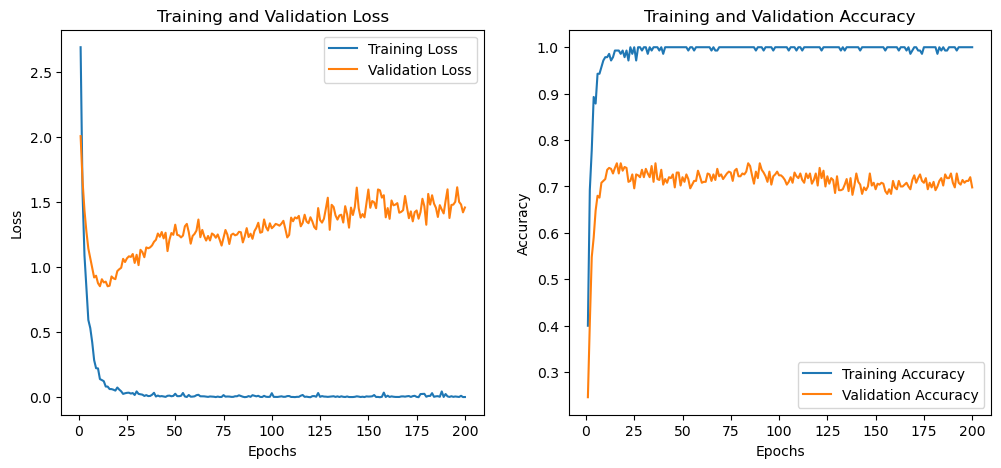

In [33]:
# Plotting the learning curves
epochs = range(1, 201)

# Plot loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


### Section 4

Ablation 1: Remove Batch Normalization (Class: DeepGCNWithoutBatchNorm)

In [13]:
class DeepGCNWithoutBatchNorm(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3):
        super(DeepGCNWithoutBatchNorm, self).__init__()

        self.convs = torch.nn.ModuleList()

        self.convs.append(GCNConv(in_channels, hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        self.convs.append(GCNConv(hidden_channels, out_channels))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for conv in self.convs[:-1]:
            x = F.relu(conv(x, edge_index))
            x = F.dropout(x, training=self.training)

        x = self.convs[-1](x, edge_index)

        return F.log_softmax(x, dim=1)


Ablation 2: Remove Dropout (Class: DeepGCNWithoutDropout)

In [14]:
class DeepGCNWithoutDropout(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3):
        super(DeepGCNWithoutDropout, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()  # Batch normalization layers

        self.convs.append(GCNConv(in_channels, hidden_channels))
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        self.convs.append(GCNConv(hidden_channels, out_channels))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for conv, bn in zip(self.convs[:-1], self.bns):
            x = F.relu(bn(conv(x, edge_index)))  # No dropout
        x = self.convs[-1](x, edge_index)

        return F.log_softmax(x, dim=1)


Ablation 3: Fewer Layers (Class: DeepGCNWithFewerLayers)
Here you can reduce the number of layers to 2, for example:

In [15]:
class DeepGCNWithFewerLayers(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super(DeepGCNWithFewerLayers, self).__init__()
        
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(GCNConv(in_channels, hidden_channels))
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        if num_layers > 2:
            for _ in range(num_layers - 2):
                self.convs.append(GCNConv(hidden_channels, hidden_channels))
                self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        self.convs.append(GCNConv(hidden_channels, out_channels))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for conv, bn in zip(self.convs[:-1], self.bns):
            x = F.relu(bn(conv(x, edge_index)))
            x = F.dropout(x, training=self.training)

        x = self.convs[-1](x, edge_index)

        return F.log_softmax(x, dim=1)


In [24]:
# Train each model
def train_model(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

# Test the models
def test_model(model):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    acc = correct / data.test_mask.sum().item()
    return acc



In [25]:
# Baseline model with BatchNorm and Dropout
model_baseline = DeepGCNWithBatchNorm(dataset.num_node_features, 64, dataset.num_classes)
train_model(model_baseline)
baseline_acc = test_model(model_baseline)

# Model without BatchNorm
model_no_bn = DeepGCNWithoutBatchNorm(dataset.num_node_features, 64, dataset.num_classes)
train_model(model_no_bn)
no_bn_acc = test_model(model_no_bn)

# Model without Dropout
model_no_dropout = DeepGCNWithoutDropout(dataset.num_node_features, 64, dataset.num_classes)
train_model(model_no_dropout)
no_dropout_acc = test_model(model_no_dropout)

# Model with Fewer Layers
model_fewer_layers = DeepGCNWithFewerLayers(dataset.num_node_features, 64, dataset.num_classes, num_layers=2)
train_model(model_fewer_layers)
fewer_layers_acc = test_model(model_fewer_layers)

# Compare accuracies
print(f'Baseline Accuracy: {baseline_acc}')
print(f'No BatchNorm Accuracy: {no_bn_acc}')
print(f'No Dropout Accuracy: {no_dropout_acc}')
print(f'Fewer Layers Accuracy: {fewer_layers_acc}')


Baseline Accuracy: 0.753
No BatchNorm Accuracy: 0.788
No Dropout Accuracy: 0.714
Fewer Layers Accuracy: 0.767


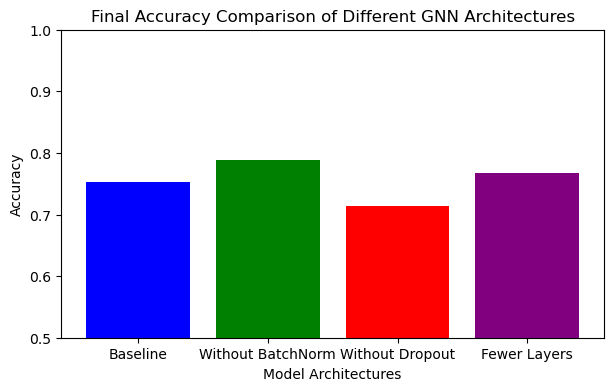

In [30]:
# Model names and their final accuracies
model_names = ['Baseline', 'Without BatchNorm', 'Without Dropout', 'Fewer Layers']
accuracies = [baseline_acc, no_bn_acc, no_dropout_acc, fewer_layers_acc]

# Plotting the bar chart for accuracies
plt.figure(figsize=(7, 4))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model Architectures')
plt.ylabel('Accuracy')
plt.title('Final Accuracy Comparison of Different GNN Architectures')
plt.ylim(0.5, 1)  # Setting the y-axis limit to emphasize differences
plt.show()


### Comparison between Multi Model Architecture

In [25]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Define the simple GCN model
class GCN(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(GCN, self).__init__()
        # First GCN layer
        self.conv1 = GCNConv(input_channels, hidden_channels)
        # Second GCN layer
        self.conv2 = GCNConv(hidden_channels, output_channels)

    def forward(self, x, edge_index):
        # First GCN layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        # Second GCN layer (produces the output)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

# Initialize the model
hidden_channels = 16  # Define the size of hidden layers
model_simple= GCN(dataset.num_node_features, hidden_channels, dataset.num_classes)

# Define the optimizer
optimizer = torch.optim.Adam(model_simple.parameters(), lr=0.01, weight_decay=5e-4)

In [26]:
def accuracy():
    model_simple.eval()  # Set the model to evaluation mode
    pred = model_simple(data.x, data.edge_index)  # Forward pass
    _, pred = pred.max(dim=1)  # Get predicted class by taking the argmax
    correct = int(pred.eq(data.y).sum().item())  # Compare predictions with true labels
    accuracy = correct / len(data.y)  # Calculate accuracy
    return accuracy

# Training loop
for epoch in range(100):
    optimizer.zero_grad()  # Clear gradients
    out = model_simple(data.x, data.edge_index)  # Forward pass
    # Compute the loss solely based on the training nodes
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    # Derive gradients
    loss.backward()
    # Update parameters based on gradients
    optimizer.step()
    
    # Print the loss and accuracy every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}: Loss: {loss.item()}')
        print(f'Test Accuracy for {epoch+1}: {accuracy()}')
        print('=====================================')

Epoch 10: Loss: 0.8058780431747437
Test Accuracy for 10: 0.7869276218611522
Epoch 20: Loss: 0.1466369777917862
Test Accuracy for 20: 0.8105612998522895
Epoch 30: Loss: 0.035385552793741226
Test Accuracy for 30: 0.8094534711964549
Epoch 40: Loss: 0.017112979665398598
Test Accuracy for 40: 0.8094534711964549
Epoch 50: Loss: 0.014339239336550236
Test Accuracy for 50: 0.8064992614475628
Epoch 60: Loss: 0.015583915635943413
Test Accuracy for 60: 0.8105612998522895
Epoch 70: Loss: 0.017467668280005455
Test Accuracy for 70: 0.8135155096011817
Epoch 80: Loss: 0.01833132468163967
Test Accuracy for 80: 0.8135155096011817
Epoch 90: Loss: 0.018004005774855614
Test Accuracy for 90: 0.8149926144756278
Epoch 100: Loss: 0.017049400135874748
Test Accuracy for 100: 0.8149926144756278


In [34]:
import matplotlib.pyplot as plt

# Initialize lists to store accuracy values for both models
simple_gcn_accuracy = []
deep_gcn_accuracy = []

# Example: store the accuracy values for each model at each epoch

# Simple GCN model training loop (add accuracy recording)
for epoch in range(100):
    optimizer.zero_grad()
    out = model_simple(data.x, data.edge_index)  # Simple GCN model
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    # Every 10 epochs, store accuracy
    if (epoch + 1) % 10 == 0:
        acc = accuracy()  # Assuming 'accuracy' function is defined for Simple GCN
        simple_gcn_accuracy.append(acc)
        print(f'Epoch {epoch+1}: Simple GCN Accuracy: {acc}')






Epoch 10: Simple GCN Accuracy: 0.8149926144756278
Epoch 20: Simple GCN Accuracy: 0.8149926144756278
Epoch 30: Simple GCN Accuracy: 0.8149926144756278
Epoch 40: Simple GCN Accuracy: 0.8149926144756278
Epoch 50: Simple GCN Accuracy: 0.8149926144756278
Epoch 60: Simple GCN Accuracy: 0.8149926144756278
Epoch 70: Simple GCN Accuracy: 0.8149926144756278
Epoch 80: Simple GCN Accuracy: 0.8149926144756278
Epoch 90: Simple GCN Accuracy: 0.8149926144756278
Epoch 100: Simple GCN Accuracy: 0.8149926144756278


In [41]:
# Initialize list to store accuracy values for Deep GCN
deep_gcn_accuracy = []

# Training loop for DeepGCNWithBatchNorm model
for epoch in range(100):
    # Call the existing train function to perform one epoch of training
    train_loss = train()  # This uses the defined train() function to train the model
    
    # Every 10 epochs, calculate and store accuracy using the test() function
    if (epoch + 1) % 10 == 0:
        acc = test()  # Call the defined test() function to evaluate the model
        deep_gcn_accuracy.append(acc)
        print(f'Epoch {epoch+1}: Loss: {train_loss:.4f}, DeepGCNWithBatchNorm Accuracy: {acc:.4f}')


Epoch 10: Loss: 0.0011, DeepGCNWithBatchNorm Accuracy: 0.8130
Epoch 20: Loss: 0.0011, DeepGCNWithBatchNorm Accuracy: 0.8120
Epoch 30: Loss: 0.0011, DeepGCNWithBatchNorm Accuracy: 0.8120
Epoch 40: Loss: 0.0011, DeepGCNWithBatchNorm Accuracy: 0.8130
Epoch 50: Loss: 0.0010, DeepGCNWithBatchNorm Accuracy: 0.8130
Epoch 60: Loss: 0.0010, DeepGCNWithBatchNorm Accuracy: 0.8130
Epoch 70: Loss: 0.0010, DeepGCNWithBatchNorm Accuracy: 0.8110
Epoch 80: Loss: 0.0010, DeepGCNWithBatchNorm Accuracy: 0.8120
Epoch 90: Loss: 0.0010, DeepGCNWithBatchNorm Accuracy: 0.8110
Epoch 100: Loss: 0.0010, DeepGCNWithBatchNorm Accuracy: 0.8140


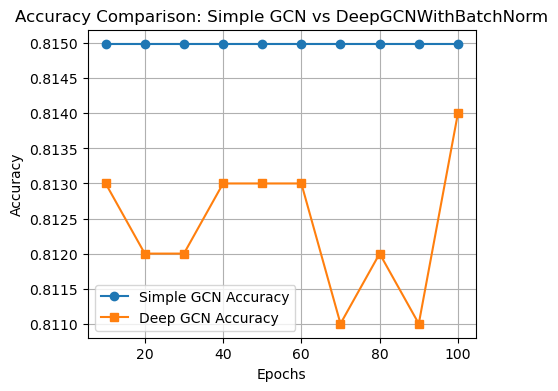

In [44]:
# Plotting the accuracy values of both models

epochs = range(10, 101, 10)  # For 10 epochs interval in Simple GCN
epochs_deep_gcn = range(10, 101, 10)  # For 10 epochs interval in Deep GCN

plt.figure(figsize=(5, 4))
plt.plot(epochs, simple_gcn_accuracy, label='Simple GCN Accuracy', marker='o')
plt.plot(epochs_deep_gcn, deep_gcn_accuracy, label='Deep GCN Accuracy', marker='s')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: Simple GCN vs DeepGCNWithBatchNorm')
plt.legend()
plt.grid(True)
plt.show()

